In [37]:
# Import libraries
import nltk
import sklearn
import pandas as pd
import numpy as np
import csv, re
import string
import codecs
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import jsonlines
import spacy

In [17]:
# Load CSV data

path_file= r"/data/wcpr_mypersonality.csv"
df = pd.read_csv(path_file, encoding='latin-1')

# Convert to jsonlines format
with jsonlines.open('myPersonality.jsonl', 'w') as writer:
    for _, row in df.iterrows():
        writer.write(row.to_dict())
        
# Load jsonlines data
data = []
with jsonlines.open('myPersonality.jsonl', 'r') as reader:
    for item in reader:
        data.append(item)

# Convert to DataFrame
df = pd.DataFrame(data)

In [18]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS',
       'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'],
      dtype='object')

In [19]:
import csv
import pandas as pd
from io import StringIO

def read_and_clean_lines(df):
    print("\nReading and cleaning text from dataframe")
    lines = []
    neurotic_flags = []

    csv_data = StringIO(df.to_csv(index=False))
    reader = csv.reader(csv_data)
    next(reader, None)
    for row in reader:
        lines.append(row[1])
        neurotic_flags.append(row[8])

    print("Read {} status posts.".format(len(lines)))
    print("Read {} labels".format(len(neurotic_flags)))
    return lines, neurotic_flags

In [20]:
read_and_clean_lines(df)


Reading and cleaning text from dataframe
Read 9917 status posts.
Read 9917 labels


(['likes the sound of thunder.',
  "is so sleepy it's not even funny that's she can't get to sleep.",
  "is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",
  'likes how the day sounds in this new song.',
  'is home. <3',
  'www.thejokerblogs.com',
  'saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.',
  'is in Kentucky. 421 miles into her 1100 mile journey home.',
  'was about to finish a digital painting before her tablet went haywire. Is now contemplating the many ways she wishes to exact her revenge on faulty technology.',
  'is celebrating her new haircut by listening to swinger music and generally looking like a doofus.',
  'has a crush on the Green Lantern.',
  'has magic on the brain.',
  'saw Transformers, Up, and Year One this week. Good movie overload. :D',
  'Who wants to meet up on schedule pick-up day at Oviedo?',
  'desires the thrill of inspiration. Also

In [21]:
# Read a set of stoplist words from filename, assuming it contains one word per line

def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

In [22]:
stop_words = load_stopwords(path_file)

Split dataset

In [23]:
# Split dataset into training items/labels

def split_training_set(lines, labels, test_size=0.2, random_seed=42):
    X_train, X_test, y_train, y_test = train_test_split(lines, labels, test_size=test_size,stratify=labels,shuffle=True)
    print("Training set label counts: {}".format(Counter(y_train)))
    print("Test set     label counts: {}".format(Counter(y_test)))
    return X_train, X_test, y_train, y_test

In [24]:
# Read the dataset in and split it into training documents/labels (X) and test documents/labels (y)

lines, neurotic_flags = read_and_clean_lines(df)
X_train, X_test, y_train, y_test = split_training_set(lines, neurotic_flags)


Reading and cleaning text from dataframe
Read 9917 status posts.
Read 9917 labels
Training set label counts: Counter({'n': 4960, 'y': 2973})
Test set     label counts: Counter({'n': 1240, 'y': 744})


Pass the above stopwords(frequently used words) list as argument to count vectorizer.
CountVectorizer tokenizes(tokenization means dividing the sentences in words) the text along with performing very basic preprocessing. It removes the punctuation marks and converts all the words to lowercase.

In [25]:
# Function to read train(X) data use stopwords, lowercase and ngram_range as arguments

def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,2)):
    training_vectorizer = CountVectorizer(stop_words=list(stopwords_arg),
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

In [26]:
# Functions to tokenize and normalize

def whitespace_tokenizer(line):
    return line.split()

def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens  

In [27]:
# Functions for ngram and filtering stopwords

def ngrams(tokens, n):
    # Returns all ngrams of size n in sentence, where an ngram is itself a list of tokens
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

Input:
lines     - a raw text corpus, where each element in the list is a string
stopwords - a set of strings that are stopwords
remove_stopword_bigrams = True or False

Output:  a corresponding list converting the raw strings to space-separated features

The features extracted should include non-stopword, non-punctuation unigrams,
plus the bigram features that were counted in collect_bigram_counts from the previous assignment
represented as underscore_separated tokens.

In [28]:
# Function to convert the raw strings to space-separated features 

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):
    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect unigram tokens as features
        # Exclude unigrams that are stopwords or are punctuation strings (e.g. '.' or ',')
        unigrams          = [token   for token in normalized_tokens
                                 if token not in stopwords and token not in string.punctuation]

        # Collect string bigram tokens as features
        bigrams = []
        bigram_tokens     = ["_".join(bigram) for bigram in bigrams]
        bigrams           = ngrams(normalized_tokens, 2) 
        bigrams           = filter_punctuation_bigrams(bigrams)
        if remove_stopword_bigrams:
            bigrams = filter_stopword_bigrams(bigrams, stopwords)
        bigram_tokens = ["_".join(bigram) for bigram in bigrams]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # feature_string = []
        feature_string = " ".join(unigrams) + " " + " ".join(bigram_tokens)

        # Add this feature string to the output
        all_features.append(feature_string)
        
    return all_features

Roll your own feature extraction.

In [29]:
# Call convert_lines_to_feature_strings() to get your features
# as a whitespace-separated string that will now represent the document.

print("Creating feature strings for training data")
X_train_feature_strings = convert_lines_to_feature_strings(X_train, stop_words)
                                                           
print("Creating feature strings for test data")
X_test_documents = convert_lines_to_feature_strings(X_test,  stop_words)
    
# Call CountVectorizer with whitespace-based tokenization as the analyzer, so that it uses exactly your features,
# but without doing any of its own analysis/feature-extraction.
X_features_train, training_vectorizer = convert_text_into_features(X_train_feature_strings, stop_words, whitespace_tokenizer)
        

Creating feature strings for training data
 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing
 Iterating through documents extracting unigram and bigram features


100%|████████████████████████████████████████████████████████████████████████████| 7933/7933 [00:05<00:00, 1526.58it/s]


Creating feature strings for test data
 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing
 Iterating through documents extracting unigram and bigram features


100%|████████████████████████████████████████████████████████████████████████████| 1984/1984 [00:01<00:00, 1318.06it/s]
C:\Users\Teja\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(
C:\Users\Teja\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [30]:
# Apply the "vectorizer" created using the training data to the test documents, to create testset feature vectors

X_test_features =  training_vectorizer.transform(X_test_documents)

logistic regression

In [31]:
# Create a logistic regression classifier trained on the featurized training data

lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_features_train, y_train)

LogisticRegression(solver='liblinear')

In [43]:
# Classify the test data and see how well you perform
    
print("Classifying test data...")
predicted_labels = lr_classifier.predict(X_test_features)
print('Accuracy  = {}'.format(metrics.accuracy_score(predicted_labels,  y_test)))
report = classification_report(predicted_labels, y_test)
print(f"Classification report for baseline:\n{report}")
#for label in ['n', 'y']:
    #print('Precision for label {} = {}'.format(label, metrics.precision_score(predicted_labels, y_test, pos_label=label)))
    #print('Recall    for label {} = {}'.format(label, metrics.recall_score(predicted_labels, y_test, pos_label=label)))

Classifying test data...
Accuracy  = 0.6451612903225806
Classification report for baseline:
              precision    recall  f1-score   support

           n       0.85      0.67      0.75      1568
           y       0.31      0.55      0.39       416

    accuracy                           0.65      1984
   macro avg       0.58      0.61      0.57      1984
weighted avg       0.73      0.65      0.67      1984



Generating plots...


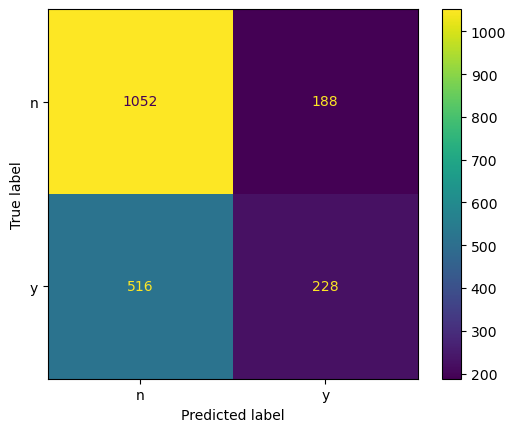

In [44]:
 # Graph the confusion matrix to show accuracies

print("Generating plots...")
ConfusionMatrixDisplay.from_predictions(y_test, predicted_labels)
plt.show()